In [1]:
from keras import layers
from keras import models
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from keras_preprocessing.image import ImageDataGenerator
import os
import pickle as plk
import pandas as pd
import numpy as np
import speechpy

In [2]:
#check GPU enabled
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
train_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\train\\'
dev_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\dev\\'
test_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\test\\'

In [5]:
example = np.load("E:\\CS224S_final_Project\\data\\melspectrograms\\train\\303_0.npy", allow_pickle=True)
input_dim = example[0].shape
print("input dim:", input_dim)

train_index_to_file = {}
idx = 0
for file in os.listdir(train_dir):
    train_index_to_file[idx] = file
    idx += 1
    
dev_index_to_file = {}
idx = 0
for file in os.listdir(dev_dir):
    dev_index_to_file[idx] = file
    idx += 1
    
test_index_to_file = {}
idx = 0
for file in os.listdir(test_dir):
    test_index_to_file[idx] = file
    idx += 1
    
train_idx = np.array(list(train_index_to_file.keys()))
dev_idx = np.array(list(dev_index_to_file.keys()))
test_idx = np.array(list(test_index_to_file.keys()))

input dim: (40, 646)


In [6]:
class MelSpectDataGen(Sequence):
    """
    Generates a dataset of log melspectrograms
    """
    def __init__(self, idx, mel_path, idx_to_file,
                 to_fit=True, batch_size=8, dim=input_dim,
                 shuffle=True):
        self.idx = idx
        self.mel_path = mel_path
        self.idx_to_file = idx_to_file
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """
        numbers of batches per epoch
        """
        return int(np.floor(len(self.idx) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idx)
    
    def __getitem__(self, index):
        """
        returns one batch of data
        """
        idx = self.idx[index * self.batch_size : (index + 1) * self.batch_size]
        files = [self.idx_to_file[i] for i in idx]
        x, y = self.get_data_from_files(files)
        for i in range(len(x)):
            x[i,] = speechpy.processing.cmvn(x[i].T, True).T
        
        if self.to_fit:
            return x, y
        else:
            return x
    
    def get_data_from_files(self, files):
        x = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, 1))
        
        for i, file in enumerate(files):
            path = os.path.join(self.mel_path, file)
            data = np.load(path, allow_pickle=True)
            x[i,] = self.process_x(data[0])
            y[i,] = data[1]
        
        return x, y
    
    def process_x(self, x):
        #new_x = np.zeros((x.shape[0], x.shape[1]))
        #new_x[:x.shape[0],] = x 

        return x # np.expand_dims(new_x, 2) # create channel size 1
        

In [7]:
# create generators
train_gen = MelSpectDataGen(train_idx, train_dir, train_index_to_file)
dev_gen = MelSpectDataGen(dev_idx, dev_dir, dev_index_to_file)
test_gen = MelSpectDataGen(test_idx, test_dir, test_index_to_file)

In [8]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras import regularizers, optimizers

model = Sequential()
#model.add(BatchNormalization(input_shape=input_dim))
model.add(Conv1D(32, 5, padding='same', input_shape = input_dim))
model.add(Activation('relu'))
model.add(Conv1D(64, 5))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512)) #change from 512
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizers.RMSprop(lr=0.00003, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 32)            103392    
_________________________________________________________________
activation (Activation)      (None, 40, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 64)            10304     
_________________________________________________________________
activation_1 (Activation)    (None, 36, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 64)            2

In [9]:
#Fitting keras model, no test gen for now
checkpoint_dir = "E:\\CS224S_final_Project"
checkpoint_path = os.path.join(checkpoint_dir, "cnn_1d_max_pool")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_gen,
                    validation_data=dev_gen,
                    epochs=100,
                    callbacks=[cp_callback])
model.evaluate_generator(generator=dev_gen)

C:\Users\lukes\anaconda3\envs\224s_proj\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
379/379 [==============================] - 7s 13ms/step - loss: 0.6533 - accuracy: 0.6528 - val_loss: 0.6744 - val_accuracy: 0.5981

Epoch 00001: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 2/100
379/379 [==============================] - 4s 11ms/step - loss: 0.6167 - accuracy: 0.7116 - val_loss: 0.6735 - val_accuracy: 0.5981

Epoch 00002: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 3/100
379/379 [==============================] - 4s 11ms/step - loss: 0.6089 - accuracy: 0.7112 - val_loss: 0.6742 - val_accuracy: 0.5972

Epoch 00003: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 4/100
379/379 [==============================] - 4s 11ms/step - loss: 0.5942 - accuracy: 0.7193 - val_loss: 0.6734 - val_accuracy: 0.5972

Epoch 00004: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 5/100
379/379 [==============================] - 4s 11ms/step - loss: 0.5837 - accuracy: 0.7181 - val_loss: 0.6732 - val_accuracy: 0.5972


379/379 [==============================] - 4s 11ms/step - loss: 0.0551 - accuracy: 0.9816 - val_loss: 4.1707 - val_accuracy: 0.5069

Epoch 00039: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 40/100
379/379 [==============================] - 4s 11ms/step - loss: 0.0651 - accuracy: 0.9773 - val_loss: 4.1602 - val_accuracy: 0.5078

Epoch 00040: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 41/100
379/379 [==============================] - 4s 11ms/step - loss: 0.0678 - accuracy: 0.9807 - val_loss: 4.4622 - val_accuracy: 0.5130

Epoch 00041: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 42/100
379/379 [==============================] - 4s 11ms/step - loss: 0.0691 - accuracy: 0.9771 - val_loss: 4.1833 - val_accuracy: 0.5026

Epoch 00042: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 43/100
379/379 [==============================] - 4s 11ms/step - loss: 0.0419 - accuracy: 0.9839 - val_loss: 4.8349 - val_accuracy: 0.5165

Epoch 0

379/379 [==============================] - 4s 10ms/step - loss: 0.0250 - accuracy: 0.9946 - val_loss: 7.3450 - val_accuracy: 0.5208

Epoch 00077: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 78/100
379/379 [==============================] - 4s 11ms/step - loss: 0.0168 - accuracy: 0.9957 - val_loss: 8.2205 - val_accuracy: 0.5217

Epoch 00078: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 79/100
379/379 [==============================] - 4s 10ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 8.6083 - val_accuracy: 0.5174

Epoch 00079: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 80/100
379/379 [==============================] - 4s 10ms/step - loss: 0.0186 - accuracy: 0.9967 - val_loss: 9.3606 - val_accuracy: 0.5217

Epoch 00080: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 81/100
379/379 [==============================] - 4s 11ms/step - loss: 0.0314 - accuracy: 0.9930 - val_loss: 9.4586 - val_accuracy: 0.5243

Epoch 0

C:\Users\lukes\anaconda3\envs\224s_proj\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[10.703719139099121, 0.5338541865348816]

In [10]:
model.evaluate_generator(generator=test_gen)

[8.498371124267578, 0.538705587387085]

In [15]:
history.history

{'loss': [0.6928094029426575,
  0.6921731233596802,
  0.6915066838264465,
  0.6908501982688904,
  0.6901981234550476,
  0.6895551681518555,
  0.6889217495918274,
  0.6882709860801697,
  0.6876540184020996,
  0.6870141625404358,
  0.686387836933136,
  0.6857938170433044,
  0.6851732730865479,
  0.6845492124557495,
  0.6839582920074463,
  0.6833471655845642,
  0.6827090382575989,
  0.6821253895759583,
  0.6814942955970764,
  0.6808756589889526,
  0.6803554892539978,
  0.67972332239151,
  0.6791343092918396,
  0.6785783767700195,
  0.6779486536979675,
  0.677368700504303,
  0.6768189072608948,
  0.6762562394142151,
  0.6756314039230347,
  0.6750566959381104,
  0.6745145916938782,
  0.6739141345024109,
  0.6734267473220825,
  0.6728494167327881,
  0.6722740530967712,
  0.6718410849571228,
  0.6712316274642944,
  0.6707205772399902,
  0.6701937913894653,
  0.6695405840873718,
  0.6690981984138489,
  0.668601930141449,
  0.668020486831665,
  0.6675505042076111,
  0.6669849157333374,
  0.6665

In [14]:
output = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

In [21]:
history.history['val_accuracy']

[0.5980902910232544,
 0.5980902910232544,
 0.5972222089767456,
 0.5963541865348816,
 0.5642361044883728,
 0.5078125,
 0.484375,
 0.5295138955116272,
 0.5251736044883728,
 0.4869791567325592,
 0.5130208134651184,
 0.484375,
 0.5199652910232544,
 0.5138888955116272,
 0.4756944477558136,
 0.4600694477558136,
 0.5269097089767456,
 0.4904513955116272,
 0.5182291865348816,
 0.4131944477558136,
 0.5199652910232544,
 0.4756944477558136,
 0.4600694477558136,
 0.4921875,
 0.4505208432674408,
 0.5355902910232544,
 0.5486111044883728,
 0.5234375,
 0.4635416567325592,
 0.4609375]

In [18]:
output

[1.459011435508728, 0.4618055522441864]

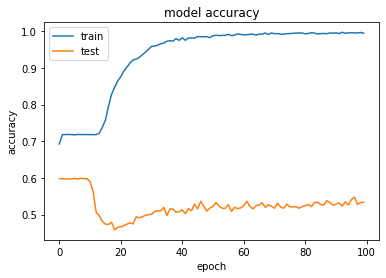

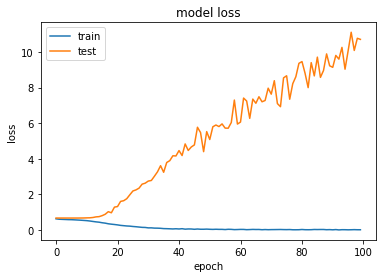

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
history.history

{'loss': [0.5970097184181213,
  0.5864580869674683,
  0.5733625292778015,
  0.5593507289886475,
  0.5499074459075928,
  0.529107928276062,
  0.5039184093475342,
  0.49000266194343567,
  0.4611984193325043,
  0.4361407458782196,
  0.4101009964942932,
  0.3861428201198578,
  0.3670750558376312,
  0.3522728979587555,
  0.3325035870075226,
  0.3121224343776703,
  0.2907268702983856,
  0.2930213212966919,
  0.2721068859100342,
  0.2542506158351898,
  0.2511141002178192,
  0.2314685732126236,
  0.22735288739204407,
  0.22089965641498566,
  0.20902900397777557,
  0.1775413602590561,
  0.18083719909191132,
  0.1746797114610672,
  0.17320701479911804,
  0.15977928042411804],
 'accuracy': [0.7194675803184509,
  0.7171381115913391,
  0.7174708843231201,
  0.720798671245575,
  0.728723406791687,
  0.7400998473167419,
  0.7527454495429993,
  0.7650582194328308,
  0.7763727307319641,
  0.7946755290031433,
  0.8053244352340698,
  0.8282861709594727,
  0.8296173214912415,
  0.841930091381073,
  0.8552